<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Segmentation-ResNet34-in-FastAI" data-toc-modified-id="Segmentation-ResNet34-in-FastAI-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Segmentation ResNet34 in FastAI</a></span><ul class="toc-item"><li><span><a href="#Half-size:-128x800" data-toc-modified-id="Half-size:-128x800-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Half-size: 128x800</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Fine-tuning" data-toc-modified-id="Fine-tuning-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Fine-tuning</a></span></li></ul></li><li><span><a href="#Original-size:-256x1600" data-toc-modified-id="Original-size:-256x1600-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Original-size: 256x1600</a></span><ul class="toc-item"><li><span><a href="#Training" data-toc-modified-id="Training-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Fine-tuning" data-toc-modified-id="Fine-tuning-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Fine-tuning</a></span></li></ul></li><li><span><a href="#Results" data-toc-modified-id="Results-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Results</a></span></li><li><span><a href="#Validation-predictions" data-toc-modified-id="Validation-predictions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Validation predictions</a></span><ul class="toc-item"><li><span><a href="#On-validation-set" data-toc-modified-id="On-validation-set-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>On validation set</a></span></li><li><span><a href="#On-test-set-for-submission" data-toc-modified-id="On-test-set-for-submission-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>On test set for submission</a></span></li></ul></li></ul></li></ul></div>

# Segmentation ResNet34 in FastAI

> Training notebook for this architecture.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from steel_segmentation.core import *
from steel_segmentation.data import *
from steel_segmentation.dataloaders import *
from steel_segmentation.models.metrics import *
from steel_segmentation.models.model import *
from steel_segmentation.models.predict import *

import fastai
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *

In [3]:
fastai.__version__

'2.2.3'

In [4]:
torch.__version__

'1.7.1+cu101'

In [5]:
torch.cuda.device_count(), torch.cuda.is_available()

(1, True)

In [6]:
#!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [7]:
torch.cuda.empty_cache()

In [8]:
!nvidia-smi

Wed Feb 10 21:26:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P5000        On   | 00000000:00:05.0 Off |                  Off |
| 26%   36C    P8     6W / 180W |   1395MiB / 16278MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
print_competition_data(models_dir)

models/ResNet18-Unet-kaggle.pth
models/.ipynb_checkpoints
models/ResNet18-Classifier-kaggle.pth
models/kaggle-FPN-ResNet34.pth
models/ResNet34-Unet-256-stage5.pth
models/ResNet34-Unet-256-stage3.pth
models/ResNet34-Unet-128-stage2.5.pth


Training a Unet model with `resnet34` encoder with progressive resizing.

In [9]:
arch = resnet34

## Half-size: 128x800

In [ ]:
# bs = 8 # 8 gb
# bs = 16 # 16 gb
bs = 32 # 24 gb
szs = (128, 800)

In [ ]:
dls = get_segmentation_dls(bs, szs)

In [ ]:
x, y = dls.one_batch()
type(x), type(y), x.shape, y.shape

(fastai.torch_core.TensorImage,
 fastai.torch_core.TensorMask,
 (32, 3, 128, 800),
 (32, 128, 800))

In [ ]:
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)
segmentation_learner.model_dir = models_dir

### Training

In [ ]:
encoder_path = Path("models") / "ResNet34_class.pt"

In [ ]:
segmentation_learner.model[0].load_state_dict(torch.load(encoder_path), strict=True)

<All keys matched successfully>

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=6.30957365501672e-05)

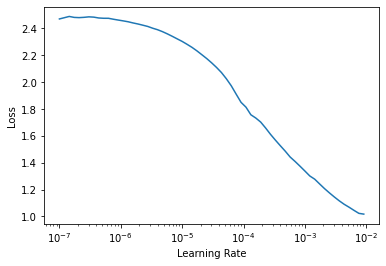

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage1
segmentation_learner.fit_one_cycle(10, lr_max=slice(3e-4, 3e-3))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.096990,0.083665,0.313438,0.854797,10:19


In [ ]:
#segmentation_learner.save("ResNet34-Unet-128-stage1")

In [ ]:
segmentation_learner.validate()

(#3) [0.04473937675356865,0.5976832730043088,0.9188908338546753]

SuggestedLRs(lr_min=1.584893179824576e-05, lr_steep=1.0964781722577754e-06)

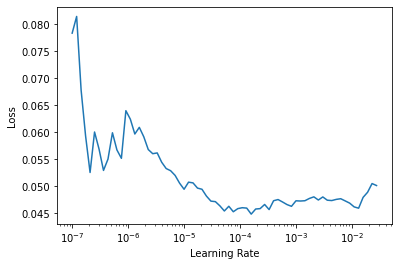

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage2
segmentation_learner.fit_one_cycle(5, lr_max=slice(3e-4, 3e-3))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.046489,0.057221,0.510095,0.904385,10:19
1,0.050522,0.048390,0.576426,0.916290,10:17
2,0.048738,0.046528,0.605400,0.915738,10:17
3,0.041545,0.044939,0.670970,0.917952,10:17
4,0.038927,0.043841,0.695421,0.921191,10:17


In [ ]:
segmentation_learner.save("ResNet34-Unet-128-stage2")

Path('models/ResNet34-Unet-128-stage2.pth')

In [ ]:
#segmentation_learner=segmentation_learner.load("ResNet34-Unet-128-stage2")

### Fine-tuning

In [ ]:
segmentation_learner.unfreeze()

SuggestedLRs(lr_min=5.248074739938602e-06, lr_steep=2.75422871709452e-06)

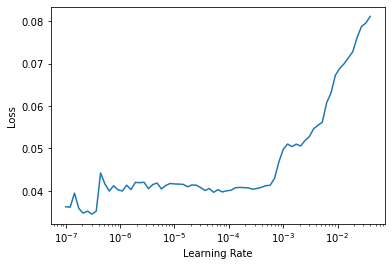

In [ ]:
segmentation_learner.lr_find()

In [ ]:
segmentation_learner.fit_one_cycle(5, lr_max=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,dice_multi,dice_kaggle,time
0,0.039433,0.043197,0.699255,0.922506,07:53
1,0.040728,0.043263,0.702246,0.921859,07:50
2,0.040855,0.042848,0.704515,0.921778,07:49
3,0.039050,0.042759,0.707800,0.924741,07:49
4,0.039491,0.042418,0.708120,0.924275,07:49


In [ ]:
segmentation_learner.save("ResNet34-Unet-128-stage3")

Path('models/ResNet34-Unet-128-stage3.pth')

## Original-size: 256x1600

In [10]:
bs = 4 # 16 gb
# bs = 8 # 24 gb

In [11]:
dls = get_segmentation_dls(bs, (256, 1600))

In [17]:
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)
segmentation_learner.model_dir = models_dir

### Training

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet34-Unet-128-stage3")

SuggestedLRs(lr_min=2.511886486900039e-06, lr_steep=6.309573450380412e-07)

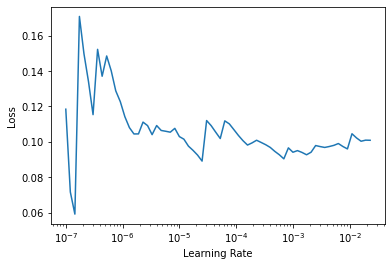

In [ ]:
segmentation_learner.lr_find()

Training for few epochs due GPU time limit with `GradientAccumulation` callback.

In [ ]:
# stage1
lr = slice(1e-4, 1e-3)
epochs = 3
segmentation_learner.fit_one_cycle(epochs, lr_max=lr, cbs=GradientAccumulation(bs*2))

epoch,train_loss,valid_loss,mod_dice_multi,dice_kaggle,time
0,0.065292,0.048253,0.650844,0.908896,31:08
1,0.058428,0.047692,0.684010,0.913800,30:57
2,0.048001,0.045992,0.685474,0.911532,30:57


In [ ]:
segmentation_learner.save("ResNet34-Unet-256-stage1")

Path('models/ResNet34-Unet-256-stage1.pth')

### Fine-tuning

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet34-Unet-256-stage3")

In [ ]:
segmentation_learner.summary()

DynamicUnet (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 128 x 800  
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                      

In [ ]:
segmentation_learner.unfreeze()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=9.12010818865383e-07)

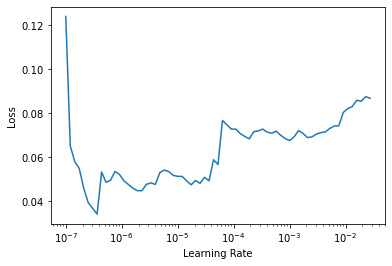

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage1
lr = slice(3e-6, 3e-5)
epochs = 4
segmentation_learner.fit_one_cycle(epochs, lr_max=lr, cbs=GradientAccumulation(bs*2))

epoch,train_loss,valid_loss,mod_dice_multi,dice_kaggle,time
0,0.066816,0.045675,0.705436,0.916705,45:53
1,0.048628,0.045439,0.704406,0.918792,45:42
2,0.049118,0.045072,0.707706,0.916294,45:39
3,0.051094,0.045032,0.715330,0.916313,45:40


In [ ]:
# stage1
lr = slice(3e-6, 3e-5)
epochs = 1
segmentation_learner.fit_one_cycle(epochs, lr_max=lr, cbs=GradientAccumulation(bs*2))

epoch,train_loss,valid_loss,mod_dice_multi,dice_kaggle,time
0,0.052788,0.045006,0.712420,0.917802,45:33


In [ ]:
segmentation_learner.save("ResNet34-Unet-256-stage5")

Path('models/ResNet34-Unet-256-stage5.pth')

In [ ]:
segmentation_learner = segmentation_learner.load("ResNet34-Unet-256-stage5")

In [ ]:
segmentation_learner.summary()

DynamicUnet (Input shape: 4)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 64 x 128 x 800  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                      

In [ ]:
segmentation_learner.unfreeze()

SuggestedLRs(lr_min=1.318256749982538e-07, lr_steep=7.585775847473997e-07)

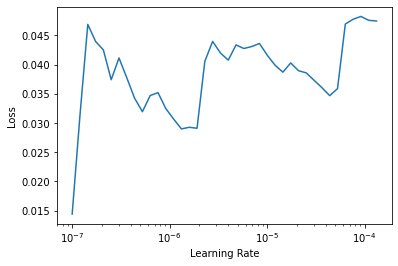

In [ ]:
segmentation_learner.lr_find()

In [ ]:
# stage1
lr = slice(1e-6, 1e-5)
epochs = 3
segmentation_learner.fit_one_cycle(epochs, lr_max=lr, cbs=GradientAccumulation(bs*2))

epoch,train_loss,valid_loss,mod_dice_multi,dice_kaggle,time
0,0.040884,0.045234,0.711459,0.914604,47:08
1,0.038025,0.045686,0.706322,0.920432,47:17
2,0.055969,0.044733,0.716540,0.916534,47:19


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
segmentation_learner.save("ResNet34-Unet-256-stage5")

Path('models/ResNet34-Unet-256-stage5.pth')

## Results

In [18]:
segmentation_learner = segmentation_learner.load("ResNet34-Unet-256-stage5")

In [ ]:
segmentation_learner.validate()

(#3) [0.04599599167704582,0.6854738966965712,0.9115328788757324]

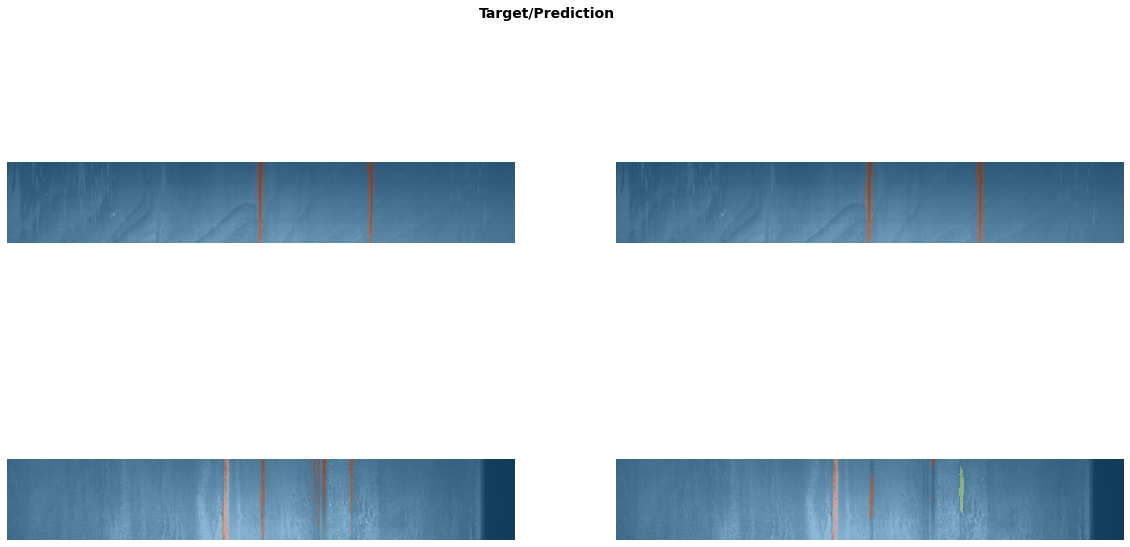

In [ ]:
segmentation_learner.show_results(figsize=(20,10))

## Validation predictions

*In italiano perché da sviluppare ancora*:

Per salvare gli output del modello è necessario:

1. fare inferenza sul validation set tramite il metodo `get_preds` (se si passa il parametro `with_decoded` permette di ottenere le probabilità invece dei digits).

2. Togliere i gradienti (se non è già stato fatto utilizzando `detach`) e convertire in un `np.array`.

3. Iterare su tutte le immagini, iterare per ogni immagine su ogni classe di difetto e utilizzare funzione `post_process` che filtra tutte le previsioni con pochi pixel data una certa soglia. 

4. Dalle maschere in `np.array` ottenute per ogni immagine, creare una codifica RLE utilizzando la funzione `mask2rle`.

5. Costruire il `pd.DataFrame` con le maschere codificate.

6. Costruire le maschere in formato `png` utilizzando la funzione `create_masks`.

Trovato il modo: utilizzare il metodo con il test set.

Trying to get the predictions for all the batches in the validation set. This worked for the 70% of the dataset but then a DataLoader worker (pid 6429) was killed (maybe because of memory).

In [11]:
bs = 4

In [12]:
dls = get_segmentation_dls_from_df(train_df=train_all, bs=bs, size=(256, 1600), with_btfms=False)

In [13]:
segmentation_learner = unet_learner(dls=dls, arch=arch, metrics=seg_metrics, pretrained=True)
segmentation_learner.model_dir = models_dir
segmentation_learner = segmentation_learner.load("ResNet34-Unet-256-stage5")

### On validation set

In [13]:
pred = Predict(dls.valid.items, segmentation_learner)

In [14]:
# test arguments
size_fold = 100
threshold = 0.5
min_size = 3000

In [15]:
df_preds = pred(size_fold, threshold, min_size)

From 0 to 100 of 2599


From 100 to 200 of 2599


From 200 to 300 of 2599


From 300 to 400 of 2599


From 400 to 500 of 2599


From 500 to 600 of 2599


From 600 to 700 of 2599


From 700 to 800 of 2599


From 800 to 900 of 2599


From 900 to 1000 of 2599


From 1000 to 1100 of 2599


From 1100 to 1200 of 2599


From 1200 to 1300 of 2599


From 1300 to 1400 of 2599


From 1400 to 1500 of 2599


From 1500 to 1600 of 2599


From 1600 to 1700 of 2599


From 1700 to 1800 of 2599


From 1800 to 1900 of 2599


From 1900 to 2000 of 2599


From 2000 to 2100 of 2599


From 2100 to 2200 of 2599


From 2200 to 2300 of 2599


From 2300 to 2400 of 2599


From 2400 to 2500 of 2599


From 2500 to 2600 of 2599


In [22]:
#pred.plot(n=20, rand=True)

In [16]:
pred.save_masks("validation_masks")

### On test set for submission

In [14]:
sub_df = pd.read_csv(path/"sample_submission.csv")
sub_df.shape

(5506, 3)

In [15]:
pred = Predict(sub_df, segmentation_learner, source_path=test_path)

In [16]:
# test arguments
size_fold = 200
threshold = 0.5
min_size = 2500

In [17]:
df_preds = pred(size_fold, threshold, min_size)

From 0 to 200 of 5506


From 200 to 400 of 5506


From 400 to 600 of 5506


From 600 to 800 of 5506


From 800 to 1000 of 5506


From 1000 to 1200 of 5506


From 1200 to 1400 of 5506


From 1400 to 1600 of 5506


From 1600 to 1800 of 5506


From 1800 to 2000 of 5506


From 2000 to 2200 of 5506


From 2200 to 2400 of 5506


From 2400 to 2600 of 5506


From 2600 to 2800 of 5506


From 2800 to 3000 of 5506


From 3000 to 3200 of 5506


From 3200 to 3400 of 5506


From 3400 to 3600 of 5506


From 3600 to 3800 of 5506


From 3800 to 4000 of 5506


From 4000 to 4200 of 5506


From 4200 to 4400 of 5506


From 4400 to 4600 of 5506


From 4600 to 4800 of 5506


From 4800 to 5000 of 5506


From 5000 to 5200 of 5506


From 5200 to 5400 of 5506


From 5400 to 5600 of 5506


In [ ]:
pred.make_masks()

In [ ]:
pred.save_submission(file_name="ResNet34-Unet-fastai")